In [152]:
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
from corner import hist2d
from astropy.table import Table

(10,)

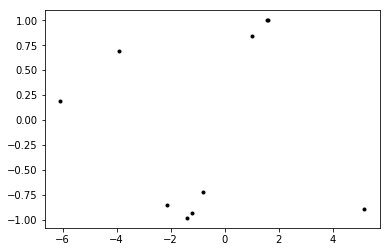

In [275]:
def func(x):
    return np.sin(x)

npts = 10
X = np.atleast_2d(np.random.uniform(-2*np.pi,2*np.pi,npts)).T
y = func(X[:,0])
pl.plot(X,y,'k.')
y.shape

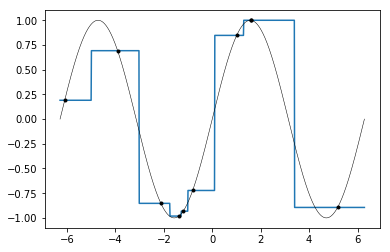

In [276]:
from sklearn.tree import DecisionTreeRegressor 

max_depth = 50
tree = DecisionTreeRegressor(max_depth=max_depth)
fit = tree.fit(X, y)
X_reg = np.atleast_2d(np.linspace(-2*np.pi, 2*np.pi, 1000)).T
y_reg = tree.predict(X_reg)

pl.plot(X_reg,y_reg)
pl.plot(X_reg,func(X_reg),'k-',lw=0.5)
pl.plot(X,y,'k.')

In [269]:
t = Table.read('data/dataset.txt', format='ascii.commented_header',data_end=1000000)


In [169]:
X = np.array([t['r_mag'], t['(u-g)'], t['(g-r)'], t['(r-i)'], t['(i-z)']]).T
y = np.array(t['specz'])


Text(0.5,0,'specz')

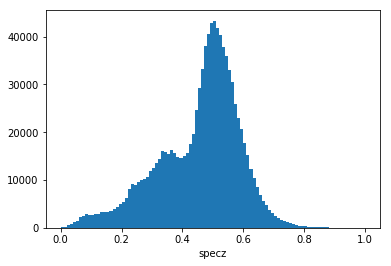

In [170]:
_ = pl.hist(y, bins=100)
pl.xlabel('specz')

In [171]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

X_train.shape


(900000, 5)

In [172]:
from sklearn.ensemble import RandomForestRegressor 
rf = RandomForestRegressor(n_jobs=8, verbose=False)

fit = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)



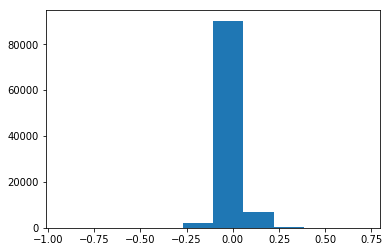

In [173]:
_ = pl.hist(y_pred-y_test)

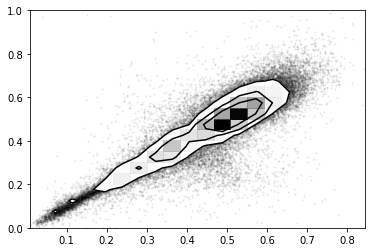

In [174]:
hist2d(y_pred,y_test)